#CIS 519 
# **K Nearest Neighbors (KNN)** 

- **Contributors:** Ty Nguyen, Halley Young, Kyle Vedder, Dan Gallagher, Pratik Kunapuli

The objective of this notebook is to walk through a working example of the K Nearest Neighbors (KNN) classification algorithm for the task of 
handwritten digit classification. The handwritten digits denote number 0-9. We will be using the famous MNIST dataset here. 



In [ ]:
# Install packages if necessary
# !python -m pip install scikit-learn

##Import Libraries

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.datasets import load_digits
from skimage import exposure
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import plotly.graph_objects as go
import seaborn as sns
import matplotlib as mpl 
# Some simple settings to make nice figures
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) # y axis's label size
mpl.rc('font', size=24) # Fig's title size 
mpl.rc('legend', fontsize=14) # Legend's fontsize 
mpl.rc('pdf', fonttype=42) # To avoid font-type-3 issue when importing figures as pdf for paper publication 
mpl.rc('font', family={'Times','monospace','sans-serif','monospace'}) # Font type priority in this order

## Dataset

Sklearn has several famous datasets built into the package, including MNIST. All we have to do is load it. After we do so, we can create training, validation, and testing data (for review on this function, refer to the Sklearn material in the coding ptimer).


In [ ]:
# load the MNIST digits dataset (we imported this dataset from sklearn in the beginning)
mnist = load_digits()
"""
**Data Set Characteristics:**
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998
"""

# take the MNIST data and construct the training and testing split, using 75% of the
# data for training and 25% for testing

X_train, X_test, y_train, y_test = train_test_split(np.array(mnist.data),
mnist.target, test_size=0.25, random_state=0)

# now, let's take 10% of the training data and use that for validation

(X_train, X_val, y_train, y_val) = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# show the sizes of each data split

print("training data points: {}".format(len(y_train)))
print("validation data points: {}".format(len(y_val)))
print("testing data points: {}".format(len(y_test)))
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

# sklearn functions come with a 'DESCR' attribute that gives you documentation on the dataset
print(f"Learn more about this data\n: {mnist['DESCR']}")

training data points: 1212
validation data points: 135
testing data points: 450
Shape of X_train: (1212, 64)
Shape of y_train: (1212,)
Learn more about this data
: .. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed t

## Data Visualization
One of the important steps in machine learning & data analysis is to understand the data. Besides the meaning and the range of the value of each attribute in the data, this step often involves data visualization.  

**Don't blindly trust the data description. It's not uncommon to have noisy/incorrect data**

First, let's just get an idea of how our data is laid out.

In [ ]:
X_train

array([[ 0.,  0.,  2., ..., 16.,  1.,  0.],
       [ 0.,  0.,  1., ...,  8.,  0.,  0.],
       [ 0.,  0.,  4., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  4., ..., 15.,  4.,  0.],
       [ 0.,  0.,  4., ..., 14.,  3.,  0.],
       [ 0.,  0.,  7., ..., 12., 12., 11.]])

In [ ]:
y_train

array([9, 0, 7, ..., 2, 6, 2])

We can get a pretty good idea of how it looks through arrays, but a Pandas table might make things just a bit clearer. We'll just look at the first 5 rows for simplicity.

In [ ]:
X_train_df = pd.DataFrame(X_train)
X_train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,2.0,13.0,8.0,6.0,0.0,0.0,0.0,0.0,7.0,14.0,14.0,16.0,0.0,0.0,0.0,0.0,7.0,9.0,3.0,16.0,4.0,0.0,0.0,0.0,5.0,14.0,15.0,16.0,4.0,0.0,0.0,0.0,0.0,3.0,2.0,13.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0,12.0,6.0,0.0,0.0,1.0,12.0,6.0,0.0,11.0,7.0,0.0,0.0,0.0,3.0,12.0,16.0,16.0,1.0,0.0
1,0.0,0.0,1.0,15.0,13.0,1.0,0.0,0.0,0.0,0.0,7.0,16.0,14.0,8.0,0.0,0.0,0.0,8.0,12.0,9.0,2.0,13.0,2.0,0.0,0.0,7.0,9.0,1.0,0.0,6.0,6.0,0.0,0.0,5.0,9.0,0.0,0.0,3.0,9.0,0.0,0.0,0.0,15.0,2.0,0.0,8.0,12.0,0.0,0.0,0.0,9.0,15.0,13.0,16.0,6.0,0.0,0.0,0.0,0.0,13.0,14.0,8.0,0.0,0.0
2,0.0,0.0,4.0,15.0,16.0,12.0,0.0,0.0,0.0,0.0,6.0,9.0,12.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,9.0,0.0,0.0,0.0,0.0,2.0,4.0,15.0,10.0,4.0,0.0,0.0,2.0,15.0,16.0,16.0,15.0,7.0,0.0,0.0,0.0,8.0,13.0,9.0,0.0,0.0,0.0,0.0,0.0,1.0,16.0,4.0,0.0,0.0,0.0,0.0,0.0,6.0,13.0,0.0,0.0,0.0,0.0
3,0.0,0.0,7.0,14.0,11.0,0.0,0.0,0.0,0.0,1.0,16.0,13.0,2.0,2.0,1.0,0.0,0.0,3.0,16.0,9.0,4.0,13.0,4.0,0.0,0.0,0.0,7.0,16.0,16.0,14.0,0.0,0.0,0.0,0.0,11.0,16.0,16.0,9.0,0.0,0.0,0.0,0.0,16.0,9.0,10.0,15.0,0.0,0.0,0.0,1.0,16.0,2.0,5.0,16.0,4.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,3.0,0.0
4,0.0,1.0,10.0,16.0,15.0,2.0,0.0,0.0,0.0,1.0,12.0,13.0,16.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,8.0,0.0,0.0,0.0,0.0,7.0,11.0,16.0,13.0,8.0,0.0,0.0,8.0,16.0,16.0,16.0,16.0,6.0,0.0,0.0,2.0,10.0,16.0,9.0,0.0,0.0,0.0,0.0,0.0,3.0,16.0,4.0,0.0,0.0,0.0,0.0,0.0,10.0,15.0,2.0,0.0,0.0,0.0


In [ ]:
y_train_df = pd.DataFrame(y_train)
y_train_df.head()

,0
0,9
1,0
2,7
3,8
4,7


As we can see, each image stored in X_train is essentially an array of 64 points, and the y_train is just a single column which holds the corresponding row's label (i.e., which digit is being depicted). However, this is still a bit unintuitive on its own, so let's try rendering the actual image.



### Data Point Visualization
As we can tell from the data description, our data consists of grayscale pixel maps, where each pixel has an intensity value range from 0 -> 16. Each map should create a gray image of a handwritten digit.

In [ ]:
# let's plot an example of each digit represented in our dataset

# Make one array of zeros to hold the images in 8x8 pixel grids, and one array to track when we have all the digits
labels_list = np.zeros(10)
imgs_list   = np.zeros([10, 8, 8], dtype=np.uint8)

# loop through each label in y_train until we get an image for all 10 digits.
for i in range(len(y_train)):
  # For each digit, we'll add one if its maps to the img_list, and set its corresponding value in labels_list to 1.
  # When all 10 spots have a value of 1, meaning we've stored a map for all 10 digits, we stop the loop.
  if labels_list.sum() == 10:
    break 
  label = int(y_train[i])
  labels_list[label] = 1
  imgs_list[label] = X_train[i].reshape([8,8])

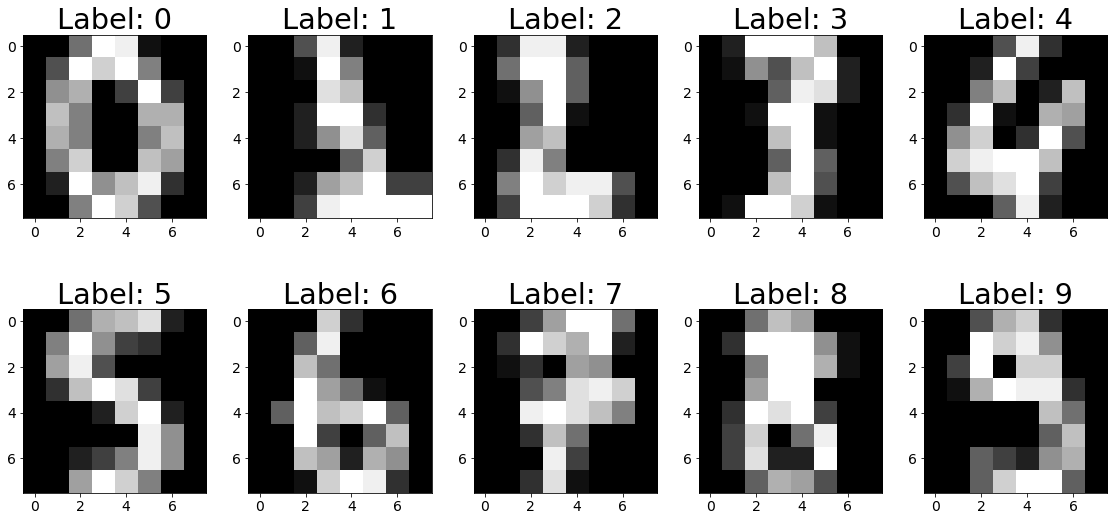

In [ ]:
num_imgs = 10
num_rows = 2
num_cols = 5


# plot images
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 8))
for i in range(num_imgs):
    ax = axes[i//num_cols, i%num_cols]
    ax.imshow(imgs_list[i], cmap='gray')
    ax.set_title(f'Label: {i}')
plt.tight_layout()
plt.show()

### Data Distributions
To get a better idea of how our pixel values are distributed, we can plot a bar plot of the frequencies of each pixel value

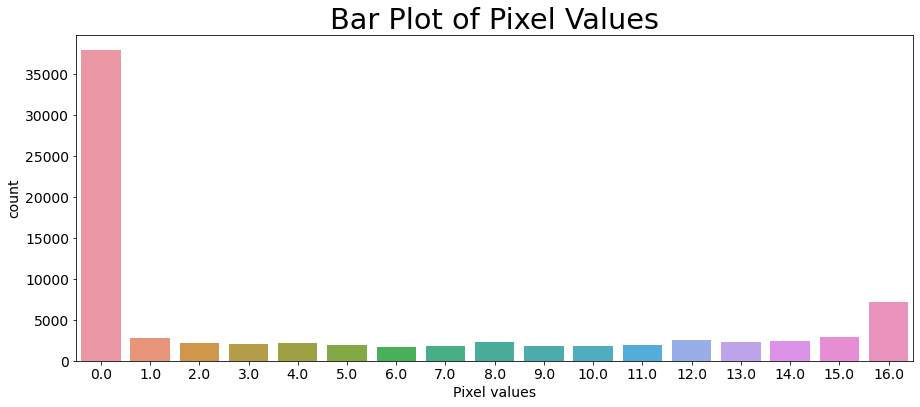

In [ ]:
plt.figure(figsize=(15,6))
sns.countplot(x = X_train.flatten()) #  convert N x 64 => (N*64,)
plt.xlabel('Pixel values')
plt.title('Bar Plot of Pixel Values')
plt.show()

It looks like the values are spread out relatively evenly, with the exception of 0 and perhaps 16. We also see that the range of pixel values is 0-16, which is consistent with the data description.

Using the grayscale images we produced, why do you think there are so many pixels with a value of 0?

### Class Distribution
It's also very important to know the distribution of object classes in the dataset to handle a potential class imbalance problem. **Class imbalance** is a critical issue when some object class has a dominant occurrences in the dataset, causing the trained model to be heavily trained on these classes while having less emphases on the others. 

Let's use an extreme example to better understand this. Think about what would happen if our dataset consisted of 20,000 "1" characters and just 20 of all the other characters. Our algorithm could get an amazing "accuracy" simply by classifying every single new digit as a 1, as it will only misclassify the tiny portion of the data that consists of non-1 digits. This, of course, is not much use to us as a classifier, as any digit we feed to it will now be identified as a "1." 

In practice, this issue, if happens, can be addressed using different methods such as using a weighted loss, and/or resampling.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



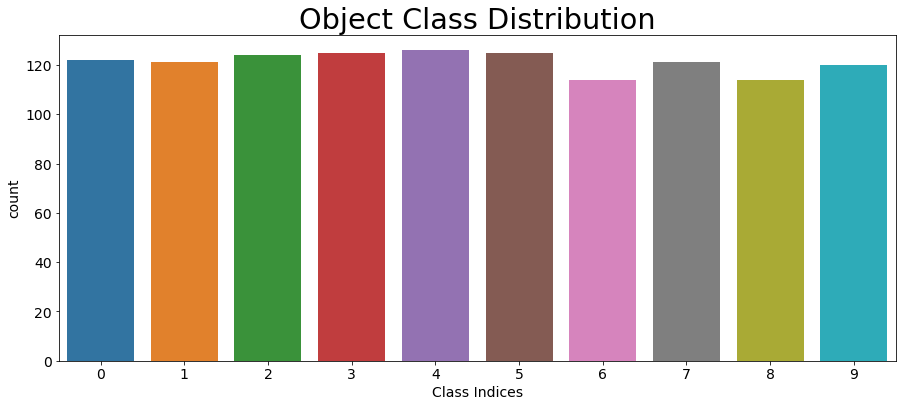

In [ ]:
# We will plot out the histogram of the labels
plt.figure(figsize=(15,6))
sns.countplot(y_train)
plt.xlabel('Class Indices')
plt.title('Object Class Distribution')
plt.show()


Lucky for us, this dataset is already well balanced so it should be good to go. We'll look with more depth at addressing imbalanced data later in the course.

##Training

We will use sklearn's KNeighborsClassifier for training. Let us use different values of 'k' to gain some insights. It's actually common practice to test multiple hyperparameters for your model, evaluating each on validation sets before evaluating the final model on the test set.

**Something to think about:** Why do we test these different hyperparameters on validation sets rather than the testing set?

In [ ]:
# initialize the values of k for our k-Nearest Neighbor classifier along with the
# list of accuracies for each value of k
k_values = range(1, 15, 1)
train_accuracies = []
valid_accuracies = []
# loop over various values of `k` for the k-Nearest Neighbor classifier

for k in k_values:
  # To start, we have to actually tell sklearn what model we're using,
  # as well as any relevant parameters for that model.
  # Here, we are feeding it k, as well as p, which corresponds to the distance metric
  # we want (2 corresponds to L2 (Euclidean) distance, where 1 would be L1 distance).
  # Remember to read the documentation for a full list of available parameters!
  model = KNeighborsClassifier(n_neighbors=k, p = 2)

  # Next, we fit the model to the training data, first giving it our data, then the labels
  model.fit(X_train, y_train)

  # Now, we want to see how our model performs on the validations set.
  # The score returns the mean accuracy- essentially the proportion of predictions
  # that were actually correct
  score = model.score(X_val, y_val)
  valid_accuracies.append(score)

  score = model.score(X_train, y_train)
  train_accuracies.append(score)     

  # There are many different metrics one could use to score a model, which we'll
  # we'll learn more about later in the course


NameError: ignored

## Learning Curve

Finally, we will plot how different k values fare against our validation set. This will let us see with which k value we might want to proceed for our final model.

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = list(k_values), 
                        y = valid_accuracies,
                        mode='lines',
                        name='Validation Accuracy'))
fig.add_trace(go.Scatter(x = list(k_values), 
                        y = train_accuracies,
                        mode='lines',
                        name='Training Accuracy'))
fig.update_layout(title='Validation Accuracy v.s. K Values',
                  yaxis_title='Validation Accuracy',
                  xaxis_title='K Values'
                  )
fig.show()

- Can you explain the trend in the plot? 

- What do you think happens when k=1 or when k takes larger values? Why do these trends occur?

- Which optimal value of k should be chosen?

## Evaluation
Retraining with our chosen value of k, we can reevaluate the selected classifier. 

We'll start with a classification report, which will give us various performance
metrics for our model on our evaluation data

In [ ]:
# re-train our classifier using  k = 5 and predict the labels of the test data
k = 5
model = KNeighborsClassifier(n_neighbors=k_values[k])
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# show a final classification report demonstrating the accuracy of the classifier
# for each of the digits

print("EVALUATION ON TESTING DATA")
print(classification_report(y_test, predictions))


EVALUATION ON TESTING DATA
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.91      1.00      0.96        43
           2       1.00      0.98      0.99        44
           3       0.96      1.00      0.98        45
           4       1.00      0.97      0.99        38
           5       0.98      0.98      0.98        48
           6       1.00      1.00      1.00        52
           7       0.94      1.00      0.97        48
           8       1.00      0.85      0.92        48
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



To see which specific classes were predicted correctly or incorrectly, we can use a confusion matrix

In [ ]:
print(confusion_matrix(y_test, predictions, labels= model.classes_))

[[37  0  0  0  0  0  0  0  0  0]
 [ 0 43  0  0  0  0  0  0  0  0]
 [ 0  0 43  0  0  0  0  1  0  0]
 [ 0  0  0 45  0  0  0  0  0  0]
 [ 0  0  0  0 37  0  0  1  0  0]
 [ 0  0  0  0  0 47  0  0  0  1]
 [ 0  0  0  0  0  0 52  0  0  0]
 [ 0  0  0  0  0  0  0 48  0  0]
 [ 0  4  0  2  0  0  0  1 41  0]
 [ 0  0  0  0  0  1  0  0  0 46]]


This is nice for a quick and dirty look, but is rather hard to interpret. Luckily, it's pretty easy to add some labels and make it a bit more interpretable.

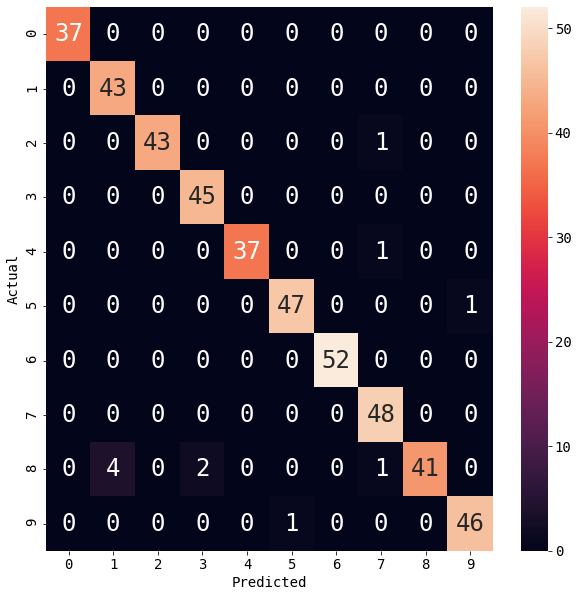

In [ ]:
def cm_heatmap(y_true, y_predicted, labels, figsize = (10,10)):
    
    # Create a confusion matrix
    cm = confusion_matrix(y_true, y_predicted)
    
    # Convert to dataframe and label the index and column names according to class labels. These will correspond with
    # the labels for each row and column in the matrix.
    # We can pass in model.classes_ to get a list of the class labels
    cm = pd.DataFrame(cm, index= labels, columns= labels)
    
    # Label the index and column axes- this will correspond with our heatmap's x and y axes
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    
    
    # Set the figure size
    plt.figure(figsize=figsize)
    # Create a heatmap, using our confusion matrix as data, and annotate with the
    # confusion matrix to see exact numbers.
    sns.heatmap(cm, annot = cm)
    plt.show()


cm_heatmap(y_test, predictions, model.classes_)

What does this confusion matrix tell you about the performance of our model? Does our model perform equally across all digits?

Predicted digit :  3


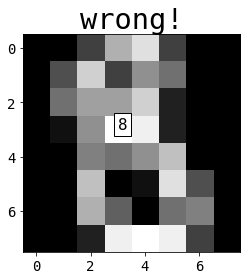

Predicted digit :  9


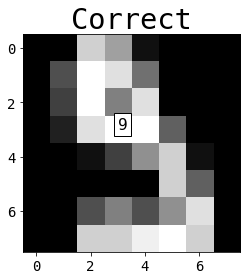

Predicted digit :  5


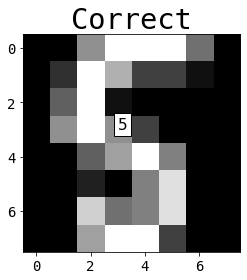

Predicted digit :  7


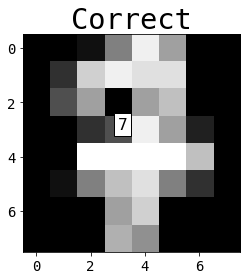

Predicted digit :  4


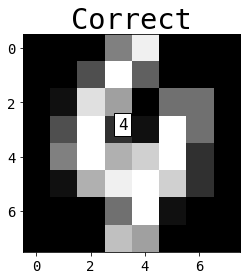

In [ ]:
# displaying results for a few digits
for i in np.random.randint(0, high=len(y_test), size=(5,)):
  # grab the image and classify it
  image = X_test[i]
  prediction = model.predict([image])[0]
  
  # show the prediction
  imgdata = np.array(image, dtype='float')
  pixels = imgdata.reshape((8,8))
  plt.figure()
  plt.imshow(pixels,cmap='gray')
  plt.annotate(y_test[i],(3,3),bbox={'facecolor':'white'},fontsize=16)
  # show correct or wrong
  title = 'Correct' if prediction == y_test[i] else 'wrong!'
  plt.title(title)
  print("Predicted digit : ",prediction)
  plt.show()

How did our final model perform? Did this surprise you?